In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [3]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)


Found and verified ./notMNIST_large.tar.gz
Found and verified ./notMNIST_small.tar.gz


In [4]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./notMNIST_large already present - Skipping extraction of ./notMNIST_large.tar.gz.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small already present - Skipping extraction of ./notMNIST_small.tar.gz.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


In [5]:
Image(filename='notMNIST_large/A/emlwZXJoZWFkLnR0Zg==.png') #uses IPython.display

In [6]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
        
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800) 

./notMNIST_large/A.pickle already present - Skipping pickling.
./notMNIST_large/B.pickle already present - Skipping pickling.
./notMNIST_large/C.pickle already present - Skipping pickling.
./notMNIST_large/D.pickle already present - Skipping pickling.
./notMNIST_large/E.pickle already present - Skipping pickling.
./notMNIST_large/F.pickle already present - Skipping pickling.
./notMNIST_large/G.pickle already present - Skipping pickling.
./notMNIST_large/H.pickle already present - Skipping pickling.
./notMNIST_large/I.pickle already present - Skipping pickling.
./notMNIST_large/J.pickle already present - Skipping pickling.
./notMNIST_small/A.pickle already present - Skipping pickling.
./notMNIST_small/B.pickle already present - Skipping pickling.
./notMNIST_small/C.pickle already present - Skipping pickling.
./notMNIST_small/D.pickle already present - Skipping pickling.
./notMNIST_small/E.pickle already present - Skipping pickling.
./notMNIST_small/F.pickle already present - Skipping pi

In [7]:
print(test_datasets[0]);
print(len(test_datasets[1])); #just the length of the string filename
print(len(test_datasets));

./notMNIST_small/A.pickle
25
10


52909

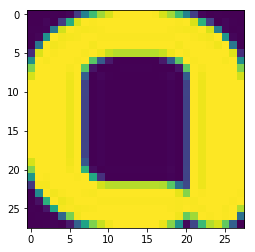

In [8]:
tmp = open(train_datasets[0], 'rb')
As = pickle.load(tmp)
plt.imshow(As[1])
len(As)

In [9]:
As.shape
As[1,1:3,1:3]

array([[-0.5       , -0.48431373],
       [-0.49607843, -0.49215686]], dtype=float32)

In [10]:
#Problem 2
for data in train_datasets:
    tmp = open(data, 'rb')
    letter_ndarray = pickle.load(tmp)
    print(letter_ndarray.shape)

(52909, 28, 28)
(52911, 28, 28)
(52912, 28, 28)
(52911, 28, 28)
(52912, 28, 28)
(52912, 28, 28)
(52912, 28, 28)
(52912, 28, 28)
(52912, 28, 28)
(52911, 28, 28)


In [11]:
np.ndarray(4, dtype=np.int32)

array([-1090519040, -1091045384, -1090650626, -1090782212], dtype=int32)

In [12]:
print(enumerate(test_datasets))

In [13]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [14]:
print(train_labels[10000:10020])
print(train_labels[20000:20020])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [15]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

In [16]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [17]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506


In [45]:
#compare time of two methods

import time;
t1 = time.time()

num_duplicates = 0;
for i in np.arange(1000): 
    for j in np.arange(1000): 
        if np.array_equal(train_dataset[i], valid_dataset[j]):
            num_duplicates += 1
print(num_duplicates)

print("--- %s seconds ---" % (time.time() - t1))

t1 = time.time()

num_duplicates = 0;
for i in np.arange(1000): #len(train_dataset)
    for j in np.arange(1000): #len(valid_dataset) 
        #print(np.subtract(train_dataset[i,1:3,1:3], valid_dataset[j,1:3,1:3]))
        if not np.any(np.subtract(train_dataset[i,:,:], valid_dataset[j,:,:])):
            num_duplicates += 1
print(num_duplicates)

print("--- %s seconds ---" % (time.time() - t1))

##conclusion: np.array_equal is faster

141
--- 4.9943687915802 seconds ---
141
--- 6.16789698600769 seconds ---


In [52]:
#number of duplicates between training and validation sets
import time;
t1 = time.time()

num_duplicates = 0;
for i in np.arange(len(train_dataset)):
    if i % 1000 == 0: #will help keep track of how far along the computation we are... going up to 200,000
        print(i)
    for j in np.arange(len(valid_dataset)): 
        if np.array_equal(train_dataset[i], valid_dataset[j]):
            num_duplicates += 1
print(num_duplicates) #208817 duplicates - how does that even make sense??! must be duplicates wihthin the validation set

print("--- %s seconds ---" % (time.time() - t1)) #took 2 hours 54 minutes

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [23]:
print(len(train_dataset))
print(len(valid_dataset))


200000
10000


In [24]:
## Problem 6¶
# Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.
# Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.
# Optional question: train an off-the-shelf model on all the data!

In [30]:
from sklearn import linear_model

print(train_dataset.shape)
print(train_labels.shape)

print(train_dataset[0, 1:5, 1:5])
print(train_labels[0:5,])

(200000, 28, 28)
(200000,)
[[-0.47647059 -0.5        -0.19803922  0.5       ]
 [-0.49607843 -0.5        -0.43333334  0.19019608]
 [-0.28039217 -0.43333334 -0.5        -0.37058824]
 [ 0.5         0.20588236 -0.32352942  0.44117647]]
[4 9 6 2 7]


In [46]:
def train_lm(n, data, data_labels):
    data = data[0:n, :, :]
    flat_data = data.reshape(data.shape[0],-1) #reshape data to be a 2D array
    labels  = data_labels[0:n,]
    logistic = linear_model.LogisticRegression(C=1e5)
    logistic.fit(flat_data, labels)
    return(logistic)

In [62]:
flat_test_data = test_dataset.reshape(test_dataset.shape[0],-1)
print(flat_test_data.shape)

n=50
my_logistic = train_lm(n, train_dataset, train_labels)
predictions = my_logistic.predict(flat_test_data)
error = np.mean(test_labels != predictions) #error rate
print(error)

n=100
my_logistic = train_lm(n, train_dataset, train_labels)
predictions = my_logistic.predict(flat_test_data)
error = np.mean(test_labels != predictions) #error rate
print(error)

n=1000
my_logistic = train_lm(n, train_dataset, train_labels)
predictions = my_logistic.predict(flat_test_data)
error = np.mean(test_labels != predictions) #error rate
print(error)

n=5000
my_logistic = train_lm(n, train_dataset, train_labels)
predictions = my_logistic.predict(flat_test_data)
error = np.mean(test_labels != predictions) #error rate
print(error)

(10000, 784)
0.5039
0.3267
0.2011
0.2567
